In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch
from itertools import combinations

### Preprocess Data

In [2]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='entsorgung_30T', 
    freq=30,
    normalize_time=True,
    )

In [3]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.08, 0.11) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha

local_variation_2 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
    )

covar = locally_long_periodic + local_variation


covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]


### Create, Train, and Perform Inference

In [ ]:

for kernel in covar_combinations:

    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='entsorgung_30T', 
    freq=30,
    normalize_time=True)

    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=kernel,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1, 
    time_agg='30T',
    machine='entsorgung',
    update_score=True
)

Iter 1 , Loss = 0.8930795258380176 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.8569709168569278 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.8209930824529419 , Noise = 0.5982182621955872
Iter 4 , Loss = 0.7851563295849647 , Noise = 0.5543860793113708
Iter 5 , Loss = 0.7494656774992126 , Noise = 0.5129663944244385
Iter 6 , Loss = 0.7139367640455913 , Noise = 0.47391772270202637
Iter 7 , Loss = 0.678614669875741 , Noise = 0.4371910095214844
Iter 8 , Loss = 0.6435677413130361 , Noise = 0.40273022651672363
Iter 9 , Loss = 0.6088597597514932 , Noise = 0.37047305703163147
Iter 10 , Loss = 0.574506981828777 , Noise = 0.3403513431549072
Iter 11 , Loss = 0.5404425470451577 , Noise = 0.31229159235954285
Iter 12 , Loss = 0.5065244219703469 , Noise = 0.2862150967121124
Iter 13 , Loss = 0.47259756240494516 , Noise = 0.2620384395122528
Iter 14 , Loss = 0.4385701270838103 , Noise = 0.23967385292053223
Iter 15 , Loss = 0.4044614735378109 , Noise = 0.2190302014350891
Iter 16 , Loss = 0.37041767367

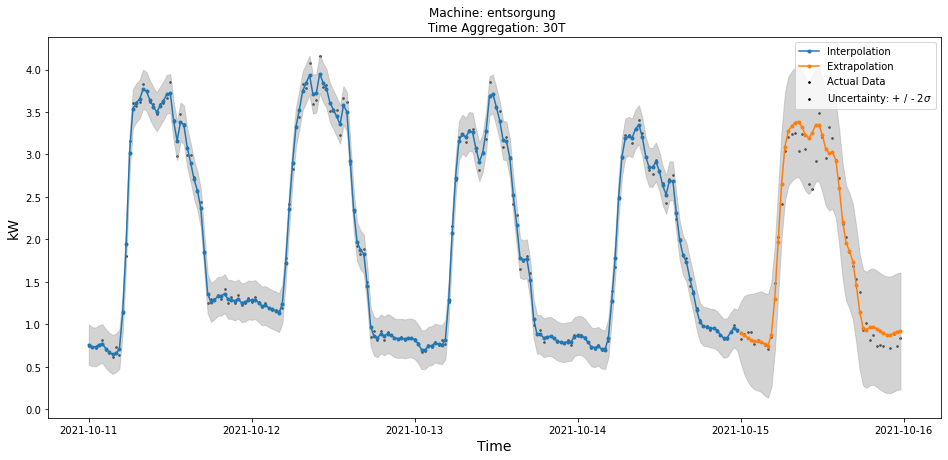

Empty DataFrame
Columns: [time, actual, machine]
Index: []


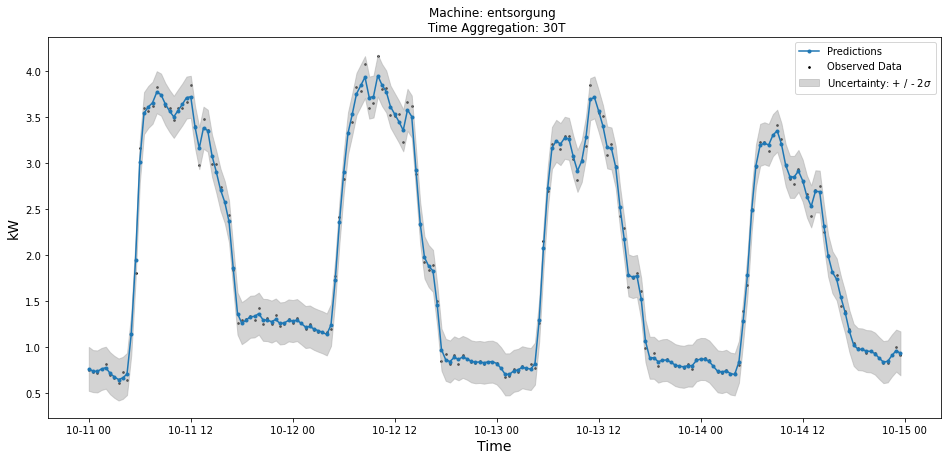

Empty DataFrame
Columns: [index, time, machine, control_limit, actual_kw, expected_kw, bound]
Index: []


/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:516: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:517: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')


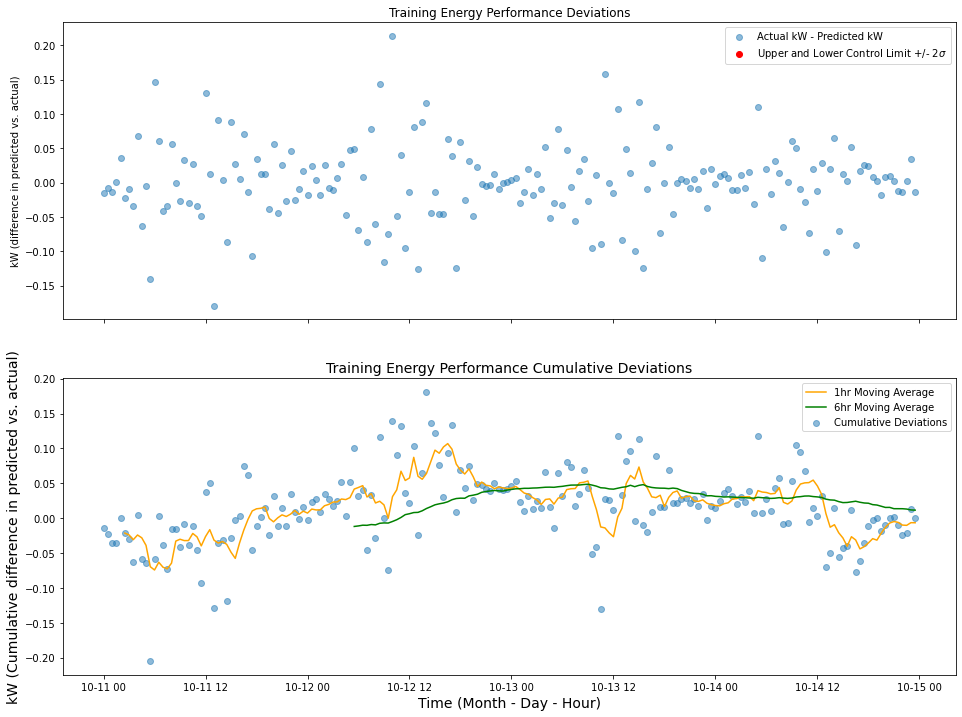

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:543: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_upper], test_deviation[test_upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:544: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_lower], test_deviation[test_lower], color='red')


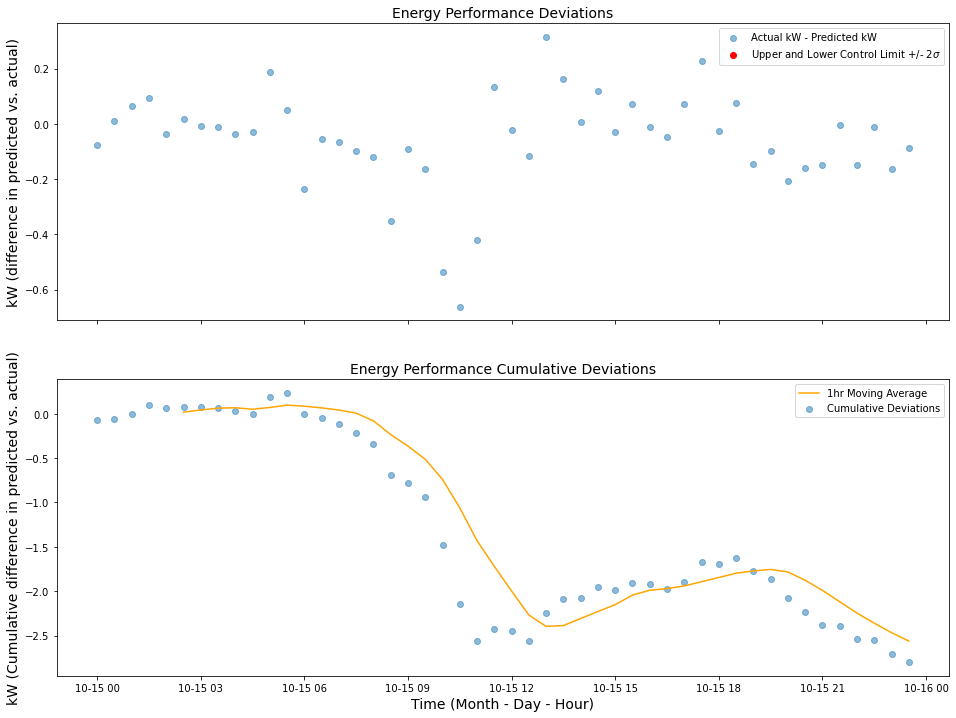

1.0 0.06286374947347216


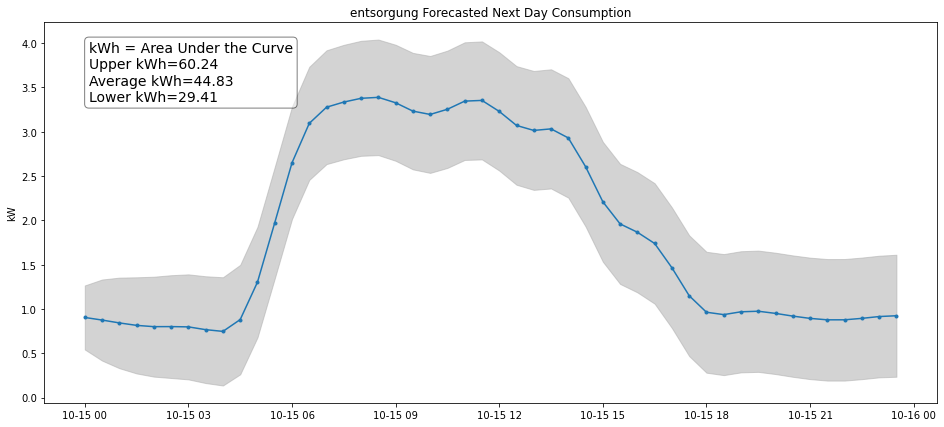

In [4]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module6,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1, 
    time_agg='30T',
    machine='entsorgung',
    update_score=False
)

In [5]:
mse, mape

(0.033962212434531895, 0.0795093851430307)

### 5 minutes agg.

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='entsorgung_5T', 
    freq=5,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.08, 0.11) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

In [ ]:
model, likelihood, mse, mape, perf_dev_upper = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1,
    time_agg='5T',
    machine='entsorgung',
    update_score=False
)

In [ ]:
mse, mape